# Multi-Output Networks and Batch Processing
-----------------------


## Dataset Loading

Load the dataset from files and provide the input matrix $\mathbf X \in \mathbb R^{(D+1)\times N}$ and the output matrix $\mathbf T \in \mathbb R^{O\times N}$.

For more information about the dataset, refer to https://archive.ics.uci.edu/ml/datasets/Student+Performance.

Categorical inputs (indexes 8-11) are skipped for now. All other entries are converted either into binary $(-1,1)$ or into an integer range $(0,1,\ldots)$. The three outputs range between 0 and 20 each.

In [29]:
import math
import numpy
np = numpy
import os

# Dataset origin: https://archive.ics.uci.edu/ml/datasets/Student+Performance

def dataset(course="mat"):
  # load dataset and provide input and target data
  # possible data files are "mat" and "por"

  # download data file from URL
  dataset_zip_file = "student.zip"
  if not os.path.exists(dataset_zip_file):
    import urllib.request
    urllib.request.urlretrieve("https://archive.ics.uci.edu/ml/machine-learning-databases/00320/student.zip", dataset_zip_file)
    print ("Downloaded datafile", dataset_zip_file)

  import zipfile
  import csv
  import io

  # collect inputs
  inputs = []
  targets = []
  # some default values: yes=1, no=-1
  yn = {"yes":1.,"no":-1.}
  # read through dataset (without actually unzippiung to a file):
  # ... open zip file
  zip = zipfile.ZipFile(dataset_zip_file)
  # ... open data file inside of zip file and convert bytes to text
  datafile = io.TextIOWrapper(zip.open(os.path.join(F"student-{course}.csv"), 'r'))
  # ... read through the lines via CSV reader, using the correct delimited
  reader = csv.reader(datafile, delimiter=";")
  # ... skip header line
  next(reader)
  for splits in reader:
    # read input values
    inputs.append([
      1.,                             #### BIAS ####
      {"GP":1.,"MS":-1.}[splits[0]],  # school
      {"M":1.,"F":-1.}[splits[1]],    # gender
      float(splits[2]),               # age
      {"U":1.,"R":-1.}[splits[3]],    # address
      {"LE3":1.,"GT3":-1.}[splits[4]],# family size
      {"T":1.,"A":-1.}[splits[5]],    # parents living together
      float(splits[6]),               # mother education
      float(splits[7]),               # father education
      # skip categorical values
      float(splits[12]),              # travel time
      float(splits[13]),              # study time
      float(splits[14]),              # failures
      yn[splits[15]],                 # extra support
      yn[splits[16]],                 # family support
      yn[splits[17]],                 # paid support
      yn[splits[18]],                 # activities
      yn[splits[19]],                 # nursery school
      yn[splits[20]],                 # higher education
      yn[splits[21]],                 # internet
      yn[splits[22]],                 # romantic
      float(splits[23]),              # family relation
      float(splits[24]),              # free time
      float(splits[25]),              # going out
      float(splits[26]),              # workday alcohol
      float(splits[27]),              # weekend alcohol
      float(splits[28]),              # health
      float(splits[29]),              # absences
    ])

    # read targets values
    targets.append([
      float(splits[30]),              # grade for primary school
      float(splits[31]),              # grade for secondary school
      float(splits[32]),              # grade for tertiary school
    ])

  print(F"Loaded dataset with {len(targets)} samples")
  return np.transpose(np.array(inputs)), np.transpose(np.array(targets))


## Assert Valid Outputs

The dataset is loaded and all target data are checked to be in range 0-20. Also, the correct dimensions of the dataset is checked.

In [30]:
# load dataset
X, T = dataset()

# check validity
D_plus1 = 27
N = 395
O = 3
assert (np.all(T) >= 0) and (np.all(T)<=20)
print("Dataset Range okay")

assert X.shape==(D_plus1,N)
print("Shape of X is",D_plus1,"x",N)

assert T.shape==(O,N)
print("Shape of T is",O,"x",N)

Loaded dataset with 395 samples
Dataset Range okay
Shape of X is 27 x 395
Shape of T is 3 x 395


## Input Data Normalization

The mean and the standard deviation for the dataset is computed. Then, the input data is normalized with an implemented function that normalizes all input data using the whitening method with given mean and standard deviation.

In [31]:
# compute mean and standard deviation over dataset
mean = np.mean(X, axis=1) #average for each row
std = np.std(X, axis=1)

# ensure handling x_0 correctly
mean[0]=0
std[0]=1 #avoid division by 0

def normalize(x, mean, std):
  # standardize the given data with the given mean and standard deviation
  return ((x.T-mean)/std).T

# normalize the dataset
X = normalize(X, mean, std)

## Batch Processing

Implement a function that turns the dataset $(X,T)$ into batches of a certain batch size $B$.

In [32]:
def batch(X, T, batch_size=16):
  shuffle = np.random.permutation(T.shape[1])
  idx = 0
  while True:
    # shuffle dataset in each epoch
    yield X[:,shuffle[idx:idx + batch_size]], T[:,shuffle[idx:idx + batch_size]]
    idx += batch_size
    if (idx >= T.shape[1]):
      shuffle = np.random.permutation(T.shape[1])
      idx = 0

## Test your Batches

Ensure that the batch function returns batches in the correct size, dimension, and with the correct content.

In [33]:
# design and create test data to test the batch processing function
xx = np.arange(0,40,2)
XX=np.array([xx,10*xx]) #2x20
TT = 2*XX

for counter, (x,t) in enumerate(batch(XX, TT, 10)):
  # test that the batches are in the desired form and content
  assert np.all(t==2*x)

  # run this for a couple of batches, to ensure that it works over some epochs
  if counter == 20: break

print("Batches are as expected")

Batches are as expected


## Multi-Output Network

Implement a multi-target network that computes the output matrix $\mathbf Y$ for a given input dataset/batch $\mathbf X$ and given parameters $\Theta=(\mathbf W^{(1)}, \mathbf W^{(2)})$. 
The function returns both the output of the hidden units $\mathbf H$ as well as the network output $\mathbf Y$. The activation function is chosen to be $\tanh$.

In [34]:
def network(X, Theta):
  W1, W2 = Theta

  # compute activation
  A = np.matmul(W1, X)

  # compute hidden unit output
  H = (np.exp(A) - np.exp(-A)) / (np.exp(A) + np.exp(-A))
  H[0] = 1

  # compute network output
  Y = np.dot(W2, H)

  return Y, H

## Loss Implementation

Implement a function that computes the loss $\mathcal J^{L_2}_\Theta$ for a given network output $\mathbf Y$ and targets $\mathbf T$.

In [35]:
def loss(Y, T):
  N=len(Y[0])
  return 1/N*np.linalg.norm(Y-T, "fro")**2 #Frobenius norm

## Gradient Implementation

Implement a function that computes the gradient $\nabla_\Theta\mathcal J^{L_2}$ for both weight matrices $\Theta=(\mathbf W^{(1)}, \mathbf W^{(2)})$.

In [36]:
def gradient(X, T, Y, H, Theta):
  W1, W2 = Theta
  # first layer gradient
  g1 = (2/np.shape(Y)[1])*np.dot((np.dot(W2.T,(Y-T))*(1-H**2)),X.T)
  # second layer gradient
  g2 = (2/np.shape(Y)[1])*(np.dot((Y-T),H.T))
 
  return g1, g2

## Iterative Gradient Descent

Implement the iterative gradient descent. The loss values for each batch are stored in a list and returned.

In [37]:
def gradient_descent(X, T, Theta, B, eta=0.001):
  loss_values = []
  (W1, W2) = Theta
  max_epochs = 10000
  epoch = 0
  data_num = 0
  x_ticks = []
  # iterate over batches
  gen = batch(X, T, batch_size=B)
  for c, (x, t) in enumerate(gen):
    # compute network output
    (y, h) = network(x, (W1, W2))

    # compute gradient
    (g1, g2) = gradient(x, t, y, h, (W1, W2))

    # compute and append loss
    l = loss(y, t)

    # and apply gradient descent
    W1 -= eta * g1 
    W2 -= eta * g2 

    data_num += B
    if data_num > len(T[0]):
      epoch += 1
      data_num = 0
      loss_values.append(l)
      if (epoch >= max_epochs):
        break

  # return the obtained loss values at the end
  return loss_values

## Run Gradient Descent

The gradient descent is run twice, once as stochastic gradient descent with batch size $B=16$ and once as normal gradient descent. The weight matrices are instantiated using the Xavier method.

In [38]:
import copy

K = 20 # hidden neurons
D = len(X)
O = 3
W1 = np.random.uniform(-1/np.sqrt(D), 1/np.sqrt(D), (K,D))
W2 = np.random.uniform(-1/np.sqrt(D), 1/np.sqrt(D), (O,K))
Theta = [W1, W2]

# run gradient descent with full dataset
Theta1 = copy.deepcopy(Theta)
GD = gradient_descent(X, T, Theta1, len(X[0]), eta=0.001)

# run stochastic gradient descent with batches of size 16
Theta2 = copy.deepcopy(Theta)
SGD = gradient_descent(X, T, Theta2, 16, eta=0.001)

## Plotting Loss Progression

Plot the progression of the two gradient descent steps.

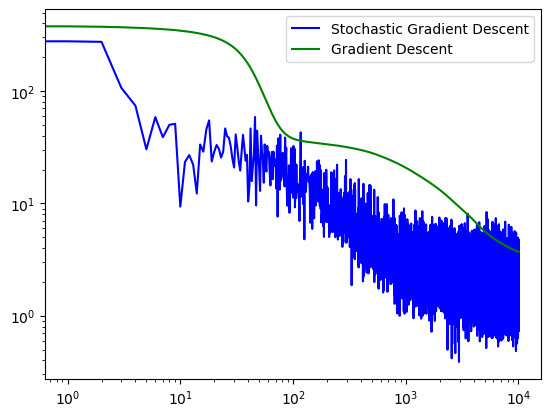

In [39]:
from matplotlib import pyplot as plt

plt.plot(SGD, "b-", label="Stochastic Gradient Descent")
plt.plot(GD, "g-", label="Gradient Descent")
plt.legend()
plt.loglog()
plt.show()

## Example Evaluation

Let's see what the network has learned. A data point that would represent a typical Swiss student is evaluated.
Appropriate information for all inputs are selected. 

See https://archive.ics.uci.edu/ml/datasets/Student+Performance for an explanation of typical values.

In [40]:
# select a specific example
example = numpy.array([[
  1., # BIAS
  -1, # school (select -1 or 1)
  1, # gender
  18, # age
  1, # adress
  1, # family size
  1, # parents living together
  1, # mother education
  1, # father education
  1, # travel time
  4, # study time
  0, # class failure before

  1, # support from school
  1, # support from the family
  1, # paid extra support
  -1, # out-of-school activities
  1, # nursery school
  1, # want to do higher ed
  1, # internet access
  1, # romantic relation

  1, # relation to family
  3, # amount of free time
  1, # go out with peers
  6, # alcoholic drinks during week
  1, # alcoholic drinks in the weekend
  1, # health status
  0 # days of absence
]]).T

example = normalize(example, mean, std)

# compute network output
prediction, h = network(example, Theta2)
print("Prediction :\t", prediction.T)


Prediction :	 [[13.70061365 14.11270483 13.59550411]]


## Influence of Data Dimensions

Let's modify particular dimensions of the input and evaluate how this changes the predicted grades.
Particularly, we test:

* if it makes a difference to be female (-1) or male (1) at index 2
* if the student takes paid classes (-1 or 1) at index 14
* if a romantic relationship influences (-1 or 1) the results at index 19
* how much of daily alcohol consumption (1-6) is still OK at index 23

Note that the indexes include the fact that we are omitting some input dimensions, so they might differ to what is listed on the webpage.


In [41]:
def predict_grade(x,theta, index, value):
  x = x.copy()
  x[index,:]=value
  return network(x,theta)[0]

# run this with the 4 modifications and their according values as seen above
# note that we use normalized data in all cases (for X, example and values)
for index in [2,14,19,23]:
  for value in numpy.unique(X[index,:]):
    print("For index: {}, value {}, the predicted output is {}"
.format(index,value,predict_grade(example,Theta2,index,value).T))

For index: 2, value -0.9481763873554659, the predicted output is [[15.37019369 15.51723238 14.30054635]]
For index: 2, value 1.0546560886092884, the predicted output is [[13.70061365 14.11270483 13.59550411]]
For index: 14, value -0.9196708066060205, the predicted output is [[17.04262318 17.37877568 16.2125328 ]]
For index: 14, value 1.0873455945507646, the predicted output is [[13.70061365 14.11270483 13.59550411]]
For index: 19, value -0.7084498152194034, the predicted output is [[12.76585579 13.35220776 13.09347182]]
For index: 19, value 1.4115325863841144, the predicted output is [[13.70061365 14.11270483 13.59550411]]
For index: 23, value -0.5406986566036547, the predicted output is [[14.4020925  14.85854328 14.76202261]]
For index: 23, value 0.583385392651312, the predicted output is [[15.20949313 15.71516985 15.79899036]]
For index: 23, value 1.7074694419062786, the predicted output is [[15.11694286 15.61399424 15.67125023]]
For index: 23, value 2.831553491161245, the predicted 